# Stock Price Prediction

In [83]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
import matplotlib.dates as mdates
from scipy.stats import pearsonr

from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.layers import Dropout

import yfinance as yf

## Microsoft Stock Prediction

### Import Data

In [84]:
msft = yf.download("MSFT")

[*********************100%***********************]  1 of 1 completed


### Normalize the Data (between 0 and 1)

In [85]:
def normalize(df):
    # Normalize the DataFrame
    df_norm = df.copy()
    scaler = MinMaxScaler(feature_range = (0,1))
    df_norm[['Open', 'High', 'Low', 'Adj Close']] = scaler.fit_transform(df_norm[['Open', 'High', 'Low', 'Adj Close']])
    
    return df_norm
msft_norm = normalize(msft)

## 1) Predicting tomorrow's closing price

In [86]:
features = ['Open', 'High', 'Low', 'Adj Close']

def offset_table(df, days):
    # Input: dataframe and days 
    # Output: The same dataframe, but with an extra Y column. The Y column is 'Adj Close' from the same table, but n days in advance

    x_temp = df[:-days].reset_index()
    y_temp = df[days:].reset_index()['Adj Close']

    result = x_temp.join(y_temp, rsuffix='Y')
    result.rename({'Adj CloseY':'Y'}, axis='columns', inplace=True)
    return result

In [87]:
msft_offset = offset_table(msft_norm, 1)

In [88]:
# Pearson R coefficient
col_name = 'Open'
pearsonr(msft_offset[col_name], msft_offset['Y'])

PearsonRResult(statistic=0.9978038012209319, pvalue=0.0)

    The above cell calculates the Pearson R coefficient between OHLC and Adj Close for the next day. As expected, there is a strong correlation between the yesterday's OHLC numbers and tomorrow's closing stock prices

### Split into train and test

In [89]:
def train_test_split(df, split_ratio):
    # Input: Takes df and split_ratio; an int between 0 and 1 representing the ratio of train:test

    train_rows = round(df.shape[0] * split_ratio) # num of rows to train vs test
    
    train = df.iloc[0:train_rows, :]  # Splitting the data
    test = df.iloc[train_rows::, :]
    X_train, Y_train = train[features], train['Y']
    X_test, Y_test = test[features], test['Y']
    
    X_train = np.array(X_train) # Reformat
    X_test = np.array(X_test)

    X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    return X_tr_t, Y_train, X_tst_t, Y_test

In [90]:
split_ratio = 0.7
X_train, Y_train, X_test, Y_test = train_test_split(msft_offset, split_ratio)

### Build Model
    Input layer -> Hidden Layer (16 Nodes) -> Output layer.

In [91]:
K.clear_session()
model = Sequential()
model.add(LSTM(16, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

In [92]:
model.fit(X_train, Y_train, epochs=50, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/50
813/813 [==============================] - 1s 664us/step - loss: 3.0661e-05
Epoch 2/50
813/813 [==============================] - 1s 663us/step - loss: 7.7670e-05
Epoch 3/50
813/813 [==============================] - 1s 666us/step - loss: 8.1684e-05
Epoch 4/50
813/813 [==============================] - 1s 674us/step - loss: 8.0828e-05
Epoch 5/50
813/813 [==============================] - 1s 675us/step - loss: 7.4205e-05
Epoch 6/50
813/813 [==============================] - 1s 669us/step - loss: 7.1485e-05
Epoch 7/50
813/813 [==============================] - 1s 667us/step - loss: 6.6925e-05
Epoch 8/50
813/813 [==============================] - 1s 667us/step - loss: 5.9130e-05
Epoch 9/50
813/813 [==============================] - 1s 666us/step - loss: 5.0326e-05
Epoch 10/50
813/813 [==============================] - 1s 669us/step - loss: 4.0963e-05
Epoch 11/50
813/813 [==============================] - 1s 663us/step - loss: 3.1935e-05
Epoch 11: early stopping


In [93]:
Y_train_pred = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(Y_train, Y_train_pred)))
r2_train = r2_score(Y_train, Y_train_pred)

Y_test_pred = model.predict(X_test)
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(Y_test, Y_test_pred)))
r2_test = r2_score(Y_test, Y_test_pred)

204/204 [==============================] - 0s 473us/step
The R2 score on the Train set is:	0.106
88/88 [==============================] - 0s 460us/step
The R2 score on the Test set is:	0.455


In [94]:
loss = model.evaluate(X_test, Y_test, batch_size=1)

2786/2786 [==============================] - 1s 470us/step - loss: 0.0389


C:\Users\Kenta Sakai\AppData\Local\Temp\ipykernel_25500\1943297921.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Y_pred'] = Y_test_pred


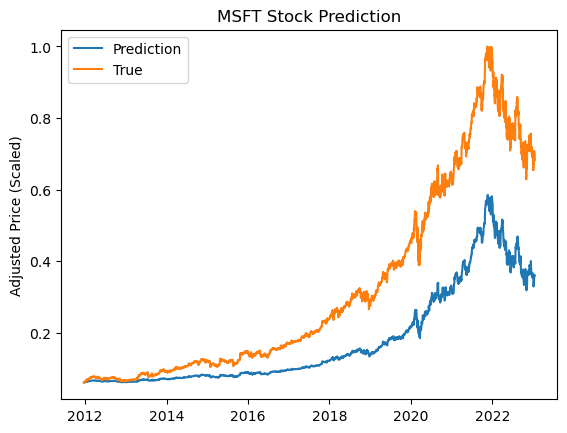

In [95]:
# Add Y_test_pred to  
train_rows = round(msft_offset.shape[0] * split_ratio)
final_df = msft_offset.iloc[train_rows::, :]
final_df['Y_pred'] = Y_test_pred

# Plot
plt.plot(final_df['Date'], final_df['Y_pred'], label = 'Prediction')
plt.plot(final_df['Date'], final_df['Y'], label = 'True')
plt.title("MSFT Stock Prediction")
plt.ylabel('Adjusted Price (Scaled)')
plt.legend()
plt.show()

    The prediction is good at forecasting the stock price patterns, but tend to undervalue the stocks. This trend gets worse as time goes on, which is reasonable because it is a time series prediction. Because we are using the earliest 70% of the data to train the model, as we move further into the future, the less the training data reflects the test data, and so we see greater variance like the plot above.

## 2) Predicting next week's closing price 

In [96]:
msft_offset = offset_table(msft_norm, 5) # offset data by 5 days
X_train, Y_train, X_test, Y_test = train_test_split(msft_offset, split_ratio)

In [97]:
model.fit(X_train, Y_train, epochs=50, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/50
813/813 [==============================] - 1s 685us/step - loss: 2.6122e-05
Epoch 2/50
813/813 [==============================] - 1s 689us/step - loss: 2.1217e-05
Epoch 3/50
813/813 [==============================] - 1s 687us/step - loss: 1.8257e-05
Epoch 4/50
813/813 [==============================] - 1s 688us/step - loss: 1.5351e-05
Epoch 5/50
813/813 [==============================] - 1s 687us/step - loss: 1.4736e-05
Epoch 6/50
813/813 [==============================] - 1s 688us/step - loss: 1.2564e-05
Epoch 7/50
813/813 [==============================] - 1s 685us/step - loss: 1.2437e-05
Epoch 8/50
813/813 [==============================] - 1s 685us/step - loss: 1.1240e-05
Epoch 9/50
813/813 [==============================] - 1s 685us/step - loss: 1.1788e-05
Epoch 10/50
813/813 [==============================] - 1s 678us/step - loss: 1.0584e-05
Epoch 11/50
813/813 [==============================] - 1s 675us/step - loss: 1.1314e-05
Epoch 12/50
813/813 [====================

In [98]:
Y_train_pred = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(Y_train, Y_train_pred)))
r2_train = r2_score(Y_train, Y_train_pred)

Y_test_pred = model.predict(X_test)
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(Y_test, Y_test_pred)))
r2_test = r2_score(Y_test, Y_test_pred)

204/204 [==============================] - 0s 488us/step
The R2 score on the Train set is:	0.713
88/88 [==============================] - 0s 483us/step
The R2 score on the Test set is:	0.324


In [99]:
loss = model.evaluate(X_test, Y_test, batch_size=1)

2785/2785 [==============================] - 1s 468us/step - loss: 0.0483


C:\Users\Kenta Sakai\AppData\Local\Temp\ipykernel_25500\1943297921.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Y_pred'] = Y_test_pred


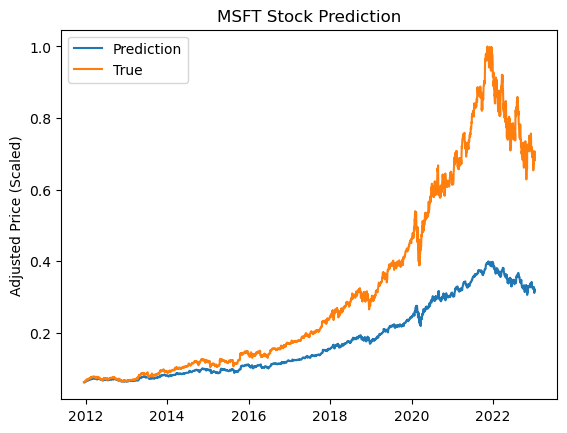

In [100]:
# Add Y_test_pred to  
train_rows = round(msft_offset.shape[0] * split_ratio)
final_df = msft_offset.iloc[train_rows::, :]
final_df['Y_pred'] = Y_test_pred

# Plot
plt.plot(final_df['Date'], final_df['Y_pred'], label = 'Prediction')
plt.plot(final_df['Date'], final_df['Y'], label = 'True')
plt.title("MSFT Stock Prediction")
plt.ylabel('Adjusted Price (Scaled)')
plt.legend()
plt.show()

    Predicting stock prices one week in the future is a bit more difficult. The issue we saw previously is more pronounced, but the model is still able to predicts patterns accurately.

## 3) AAPL Stock Forecast 

In [413]:
full_df = yf.download("AAPL")

[*********************100%***********************]  1 of 1 completed


In [414]:
# Split data into train vs test
n_days = 30 # Forecast closing price n days into the future

numrows_train = round(0.65 * full_df.shape[0])
train_df = full_df[0:numrows_train]
test_df = full_df[numrows_train:]

In [415]:
# Normalize Data between 0 and 1 
scaler = MinMaxScaler(feature_range = (0,1))
adj_close_scaled = scaler.fit_transform(train_df['Adj Close'].values.reshape(-1,1))

In [416]:
# Formatting train data

x_train = []
y_train = []

for i in range(n_days, len(adj_close_scaled)):
    x_train.append(adj_close_scaled[i-n_days:i])
    y_train.append(adj_close_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [417]:
K.clear_session()
model = Sequential()
    
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

In [418]:
model.fit(x_train, y_train, epochs=12, 
          batch_size = 32, callbacks = [checkpointer])

Epoch 1/12
215/215 [==============================] - 5s 12ms/step - loss: 0.0018
Epoch 2/12
215/215 [==============================] - 3s 12ms/step - loss: 6.4018e-04
Epoch 3/12
215/215 [==============================] - 3s 12ms/step - loss: 6.4641e-04
Epoch 4/12
215/215 [==============================] - 3s 12ms/step - loss: 4.6986e-04
Epoch 5/12
215/215 [==============================] - 3s 12ms/step - loss: 4.7294e-04
Epoch 6/12
215/215 [==============================] - 3s 12ms/step - loss: 3.5426e-04
Epoch 7/12
215/215 [==============================] - 3s 12ms/step - loss: 3.6544e-04
Epoch 8/12
215/215 [==============================] - 3s 12ms/step - loss: 4.1509e-04
Epoch 9/12
215/215 [==============================] - 3s 12ms/step - loss: 3.7887e-04
Epoch 10/12
215/215 [==============================] - 3s 12ms/step - loss: 3.5140e-04
Epoch 11/12
215/215 [==============================] - 3s 12ms/step - loss: 3.4702e-04
Epoch 12/12
215/215 [==============================] - 3

In [419]:
# Normalize test data between 0 and 1 
adj_close_scaled = scaler.transform(test_df['Adj Close'].values.reshape(-1,1))

# Format test data
x_test = []

for i in range(n_days, len(adj_close_scaled)):
    x_test.append(adj_close_scaled[i-n_days:i])

x_test = np.array(x_test)

In [435]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

116/116 [==============================] - 0s 4ms/step


In [489]:
summary_df = test_df[0:test_df.shape[0]-n_days].reset_index()
summary_df['pred'] = predicted_prices

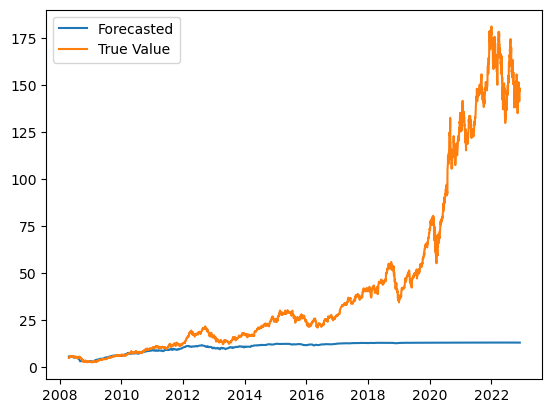

In [496]:
plt.plot(summary_df['Date'], summary_df['pred'], label = 'Forecasted')
plt.plot(summary_df['Date'], summary_df['Adj Close'], label = 'True Value')
plt.legend()
plt.show()

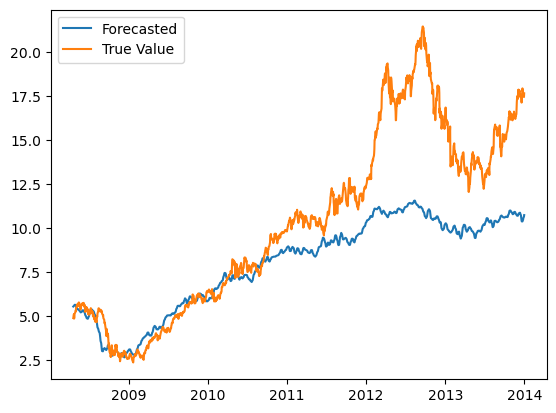

In [494]:
# summary_df.reset_index()
from2008to2014 = summary_df[(summary_df['Date'] > '2008') & (summary_df['Date'] < '2014')]
plt.plot(from2008to2014['Date'], from2008to2014['pred'], label = 'Forecasted')
plt.plot(from2008to2014['Date'], from2008to2014['Adj Close'], label = 'True Value')
plt.legend()
plt.show()

    The predictions were reasonably accurate between 2008 and 2014. 

In [ ]:
from2008to2014 = summary_df[(summary_df['Date'] > '2008') & (summary_df['Date'] < '2014')]
plt.plot(from2008to2014['Date'], from2008to2014['pred'], label = 'Forecasted')
plt.plot(from2008to2014['Date'], from2008to2014['Adj Close'], label = 'True Value')
plt.legend()
plt.show()